<font size="6">Demo for creating a transferable adversarial patch </font>  
The resulting patch is location transferable and image transferable.  
The model used for creating the adversarial patch is a pretrained Inception-V3.  
10 images are randomly selected from the Imagenet-1K for training.

In [3]:
import numpy as np
import datetime
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import interact
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

from functions import *

In [4]:
#Checking if a GPU with cuda capability is available
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


<font size="4">Loading the pretrained model and the training Dataset </font> 

In [3]:
#Loading the pretrained Inception_V3
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device=device)
model.eval()

#Functions for cropping the image and normalizing them for the model
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

crop = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
])

In [4]:
#Loading the images used for training
#The images can be changed but the label list must also be updated in this case
image_paths = glob.glob("images\*")
images = []
preprocessed_images = []
for path in image_paths:
    image = Image.open(path)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device=device)
    image_cropped = crop(image)
    images.append(image_cropped)
    preprocessed_images.append(preprocessed_image)
label_list = [22,61,37,294,7,258,28,327,292,3]

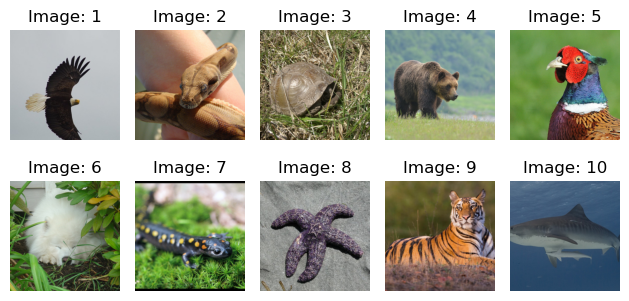

In [5]:
#Displaying all images used for training
for i in range(len(preprocessed_images)):
    plt.subplot((len(preprocessed_images)//5) + 1,5,i+1)
    plt.axis('off')
    plt.title("Image: {}".format(i+1))
    plt.imshow(images[i])
plt.tight_layout()
plt.show()

In [6]:
#Displaying with what probability the model guesses the correct label
for i in range(len(preprocessed_images)):
    image_gpu = preprocessed_images[i].to(device=device)

    with torch.no_grad():
        output = model(image_gpu)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    print("Image {} confidence: {:.3f}".format(i+1,probabilities[label_list[i]].item()))

Image 1 confidence: 0.902
Image 2 confidence: 0.991
Image 3 confidence: 0.948
Image 4 confidence: 0.961
Image 5 confidence: 0.723
Image 6 confidence: 0.884
Image 7 confidence: 0.922
Image 8 confidence: 0.999
Image 9 confidence: 0.816
Image 10 confidence: 0.978


<font size="4">Defining the patch size and training the patch </font> 

In [7]:
#Setting the size of the adversarial patch
#The patch is in a square shape of 50x50 in this example
patch_size = 50
patch_small = np.random.uniform(0.0, 1.0, (1, 3, patch_size, patch_size))
patch_small = torch.from_numpy(patch_small)

In [11]:
#Defining how many times the image is updated through back propagation using all training images
epochs = 500
#How large each step is when trained with a specific image at a random location
epsilon = 0.2
#The minimum and maximum value of pixel values in the afverserial patch
clamp_range = [-2,2]
#The desired output that the patch is tricking the model to output
target = 855


for i in range(epochs):
    loss_cum = 0
    for j in range(len(preprocessed_images)):
        xcorner = np.random.randint(0,299-patch_size-1)
        ycorner = np.random.randint(0,299-patch_size-1)
        corner_cords = [xcorner,ycorner]
        loss, patch_small = manual_single_epoch(model,preprocessed_images[j],label_list[j],epsilon,device,patch_small,\
        corner_cords,target,clamp=True,clamp_range=clamp_range)
        loss_cum += loss
        
    if (i+1)%(epochs//10) == 0: 
        avg_loss = loss_cum/len(preprocessed_images)
        print("Average loss at epoch {}: {:04f}".format(i+1,avg_loss))

Average loss at epoch 50: -9.335469
Average loss at epoch 100: -11.179649
Average loss at epoch 150: -10.651040
Average loss at epoch 200: -9.757616
Average loss at epoch 250: -11.208762
Average loss at epoch 300: -11.279225
Average loss at epoch 350: -10.734933
Average loss at epoch 400: -13.255962
Average loss at epoch 450: -11.698825
Average loss at epoch 500: -10.706151


<font size="4">Showing the results </font>

In [12]:
#Displaying the probability for the original correct label and the target label after applying the patch
for i in range(len(preprocessed_images)):
    probabilities = apply_evaluate_patch(patch_small,model,preprocessed_images[i],[30,30])
    print("Image {} original label confidence: {:.3f}, target label confidence: {:.3f}"\
          .format(i+1,probabilities[label_list[i]].item(),probabilities[target]))
    

Image 1 original label confidence: 0.000, target label confidence: 0.998
Image 2 original label confidence: 0.000, target label confidence: 0.997
Image 3 original label confidence: 0.000, target label confidence: 0.997
Image 4 original label confidence: 0.000, target label confidence: 0.997
Image 5 original label confidence: 0.000, target label confidence: 0.987
Image 6 original label confidence: 0.000, target label confidence: 0.999
Image 7 original label confidence: 0.003, target label confidence: 0.961
Image 8 original label confidence: 0.003, target label confidence: 0.994
Image 9 original label confidence: 0.003, target label confidence: 0.923
Image 10 original label confidence: 0.000, target label confidence: 0.998


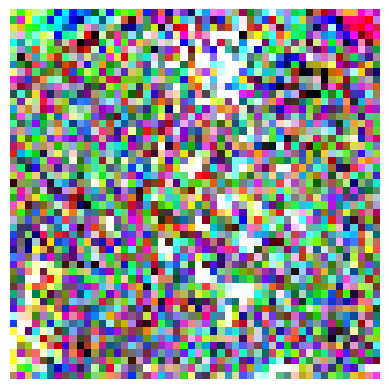

In [13]:
#Displaying the resulting adversarial patch
transform = transforms.ToPILImage()
patch_img = transform(patch_small[0])
plt.axis('off')
plt.imshow(patch_img)
